In [6]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pgeocode
import pickle
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


In [31]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)

In [4]:
base_dir = '/home/cvanderwalt/workspace/repos/ecom/'

In [5]:
data = pd.read_csv(os.path.join(base_dir, 'data/data.csv'))
data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
134694,547862,22087,PAPER BUNTING WHITE LACE,12,3/27/2011 12:54,2.95,12841.0,United Kingdom
134695,547862,21206,STRAWBERRY HONEYCOMB GARLAND,4,3/27/2011 12:54,1.65,12841.0,United Kingdom
134696,547862,21912,VINTAGE SNAKES & LADDERS,1,3/27/2011 12:54,3.75,12841.0,United Kingdom
134697,547863,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6,3/27/2011 13:07,2.95,12728.0,France


normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


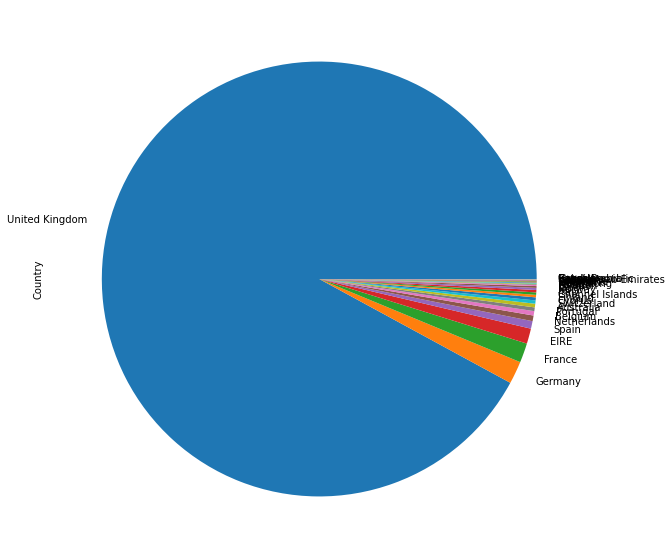

In [32]:
data.Country.value_counts(normalize=True).plot.pie()
plt.show()


In [13]:
data.groupby('StockCode').sum()['Quantity'].sort_values(ascending=False)


StockCode
84077     13757
21212     12781
85123A    12213
85099B    12047
22197      9117
          ...  
22617     -2006
84598     -2122
72732     -2472
72140F    -5368
84347     -6953
Name: Quantity, Length: 3254, dtype: int64

In [14]:
data[data['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
134566,C547857,82483,WOOD 2 DRAWER CABINET WHITE FINISH,-2,3/27/2011 12:14,6.95,13050.0,United Kingdom
134567,C547858,22797,CHEST OF DRAWERS GINGHAM HEART,-1,3/27/2011 12:16,16.95,14911.0,EIRE
134568,C547858,23178,JAM CLOCK MAGNET,-1,3/27/2011 12:16,2.89,14911.0,EIRE
134569,C547858,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-1,3/27/2011 12:16,4.95,14911.0,EIRE


## Process time

In [18]:
data['InvoiceDate'] = data['InvoiceDate'].apply(lambda x :datetime.strptime(str(x),'%m/%d/%Y %H:%M') if ':' in x else datetime.strptime(str(x),'%m/%d/%Y'))
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
134694,547862,22087,PAPER BUNTING WHITE LACE,12,2011-03-27 12:54:00,2.95,12841.0,United Kingdom
134695,547862,21206,STRAWBERRY HONEYCOMB GARLAND,4,2011-03-27 12:54:00,1.65,12841.0,United Kingdom
134696,547862,21912,VINTAGE SNAKES & LADDERS,1,2011-03-27 12:54:00,3.75,12841.0,United Kingdom
134697,547863,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6,2011-03-27 13:07:00,2.95,12728.0,France


In [38]:
data['year'] = data['InvoiceDate'].apply(lambda x :x.year)
data['month'] = data['InvoiceDate'].apply(lambda x :x.month)
data['week'] = data['InvoiceDate'].apply(lambda x :x.week)
data['day'] = data['InvoiceDate'].apply(lambda x :x.day)
data['weekday'] = data['InvoiceDate'].apply(lambda x :x.weekday())

data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,weekday,week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,2,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134694,547862,22087,PAPER BUNTING WHITE LACE,12,2011-03-27 12:54:00,2.95,12841.0,United Kingdom,2011,3,27,6,12
134695,547862,21206,STRAWBERRY HONEYCOMB GARLAND,4,2011-03-27 12:54:00,1.65,12841.0,United Kingdom,2011,3,27,6,12
134696,547862,21912,VINTAGE SNAKES & LADDERS,1,2011-03-27 12:54:00,3.75,12841.0,United Kingdom,2011,3,27,6,12
134697,547863,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6,2011-03-27 13:07:00,2.95,12728.0,France,2011,3,27,6,12


In [40]:
data_weekly = data.groupby(['year','month','week']).sum()['Quantity'].reset_index()

<BarContainer object of 18 artists>

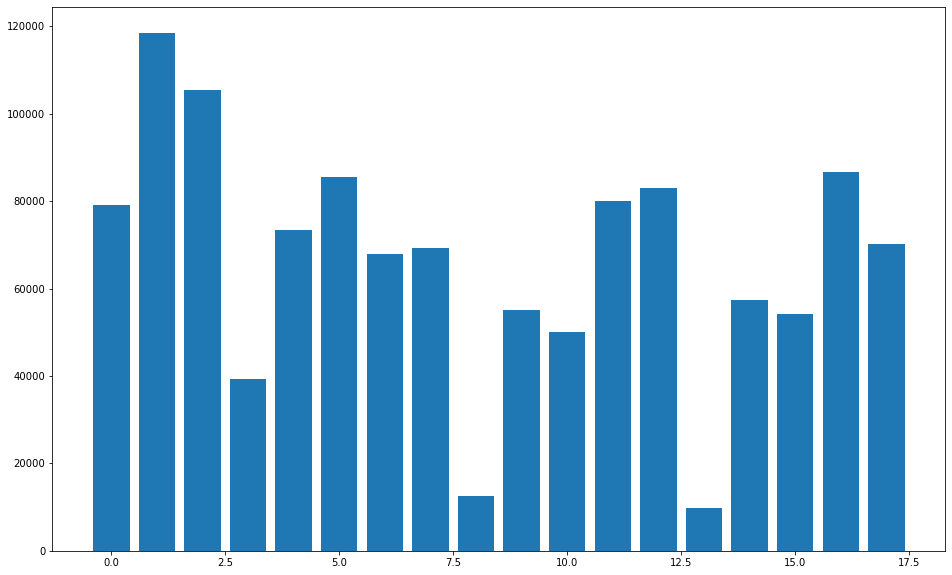

In [41]:
plt.bar(data_weekly.index, data_weekly.Quantity)

In [ ]:
sns.pairplot(data = data, vars=['Quantity','weekday','UnitPrice','month','weekday'])
plt.show()


In [ ]:
profile = ProfileReport(api_quotes, title="Pandas Profiling Report for Sales Data", explorative=True)


In [ ]:
profile.to_notebook_iframe()


In [ ]:
profile.to_file("sales_feature_report.html")
